In [23]:
import os
from pathlib import Path
from typing import Final

import numpy as np
import skimage as sk

import commonfunctions

In [24]:
def read_image(image_path: Path) -> np.ndarray:
    """Reads an image from a file, converts it to grayscale if it's 
    in RGB, and resizes it.

    The function uses the skimage library to perform its operations. It first reads
    the image from the specified file path. If the image is in RGB format, it is 
    converted to grayscale. Finally, the image is resized to a fixed size of 128x64 
    pixels.

    Parameters:
    - image_path (str): The file path of the image to be read.

    Returns:
    np.ndarray: The processed image as a NumPy array. The image will be in grayscale
                and of size 128x64 pixels.
    """
    img: np.ndarray = sk.io.imread(image_path)
    if len(img.shape) == 3:
        img = sk.color.rgb2gray(img)
    img = sk.transform.resize(img, (128, 64))

    return img

In [25]:
def compute_gradient(img: np.ndarray, grad_filter: np.ndarray) -> np.ndarray:
    """Computes the gradient of an image using a convolution with a gradient filter.

    This function applies a specified gradient filter to the input image to compute its gradient.
    It handles images of arbitrary size, padding the original image before applying the filter
    and then cropping the result back to the original image size.

    Parameters:
    - img (np.ndarray): The input image as a 2D NumPy array.
    - grad_filter (np.ndarray): The gradient filter as a 2D NumPy array, typically a small kernel.

    Returns:
    np.ndarray: The gradient image as a 2D NumPy array, of the same size as the input image.
    """
    ts = grad_filter.shape[0]

    new_img = np.zeros((img.shape[0] + ts - 1, img.shape[1] + ts - 1))

    new_img[int((ts-1)/2.0):img.shape[0] + int((ts-1)/2.0), 
            int((ts-1)/2.0):img.shape[1] + int((ts-1)/2.0)] = img

    result = np.zeros((new_img.shape))
    
    for r in np.uint16(np.arange((ts-1)/2.0, img.shape[0]+(ts-1)/2.0)):
        for c in np.uint16(np.arange((ts-1)/2.0, img.shape[1]+(ts-1)/2.0)):
            curr_region = new_img[r-np.uint16((ts-1)/2.0):r+np.uint16((ts-1)/2.0)+1, 
                                  c-np.uint16((ts-1)/2.0):c+np.uint16((ts-1)/2.0)+1]
            curr_result = curr_region * grad_filter
            score = np.sum(curr_result)
            result[r, c] = score

    result_img = result[np.uint16((ts-1)/2.0):result.shape[0]-np.uint16((ts-1)/2.0), 
                        np.uint16((ts-1)/2.0):result.shape[1]-np.uint16((ts-1)/2.0)]

    return result_img

In [26]:
def compute_gradient_magnitude(horizontal_gradient: np.ndarray, vertical_gradient: np.ndarray) -> np.ndarray:
    """Computes the magnitude of the gradient from the horizontal and vertical gradient components.

    This function calculates the gradient magnitude at each pixel of an image, which is
    useful in edge detection algorithms. The gradient magnitude is calculated as the square root
    of the sum of the squares of the horizontal and vertical gradients.

    Parameters:
    - horizontal_gradient (np.ndarray): A 2D NumPy array representing the horizontal gradient of the image.
    - vertical_gradient (np.ndarray): A 2D NumPy array representing the vertical gradient of the image.

    Hints:
        - Use np.power() to square the gradients.
        - Use np.sqrt() to compute the square root of the sum of the squares.

    Returns:
    np.ndarray: A 2D NumPy array representing the gradient magnitude of the image.
    """
    horizontal_gradient = np.power(horizontal_gradient, 2)
    vertical_gradient = np.power(vertical_gradient, 2)
    gradient_sum = horizontal_gradient + vertical_gradient
    res = np.sqrt(gradient_sum)
    return res

In [27]:
def compute_gradient_direction(horizontal_gradient: np.ndarray, vertical_gradient: np.ndarray) -> np.ndarray:
    """Computes the direction of the gradient from the horizontal and vertical gradient components.

    This function calculates the angle of the gradient at each pixel of an image. The gradient direction
    is given by the arctangent of the vertical gradient divided by the horizontal gradient. A small value 
    (1e-5) is added to the horizontal gradient to avoid division by zero. The resulting angles are 
    converted from radians to degrees and normalized to the range [0, 180) degrees.

    Parameters:
    - horizontal_gradient (np.ndarray): A 2D NumPy array representing the horizontal gradient of the image.
    - vertical_gradient (np.ndarray): A 2D NumPy array representing the vertical gradient of the image.

    Hints:
        - Use np.arctan() to compute the arctangent of the gradients.
        - Use np.rad2deg() to convert the angles from radians to degrees.
        - Use np.mod() or % to normalize the angles to the range [0, 180) degrees.

    Returns:
    np.ndarray: A 2D NumPy array representing the gradient direction of the image, in degrees.
    """
    epsilon = 1e-5
    modified_horizontal_gradient = np.where(horizontal_gradient == 0, epsilon, horizontal_gradient)
    arctan_of_grads = np.arctan(vertical_gradient, modified_horizontal_gradient)
    arctan_deg = np.rad2deg(arctan_of_grads)
    res = np.mod(arctan_deg, 180)
    return res

In [28]:
def find_nearest_bins(curr_direction: float, hist_bins: np.ndarray) -> (int, int):
    """TODO: Implement this function to find the two histogram bins nearest to the current direction.

    Parameters:
    - curr_direction (float): The current gradient direction at a pixel in the cell.
    - hist_bins (np.ndarray): An array of histogram bin edge values.

    Returns:
    - (int, int): A tuple containing the indices of the two nearest bins.

    Hints for implementation:
    1. Calculate the absolute difference between the current direction and each histogram bin.
    2. Handle edge cases where the direction is less than the first bin or greater than the last bin.
    3. In other cases, find the bin with the minimum difference (the closest bin).
    4. Determine the second closest bin considering the circular nature of the histogram.
    """
    n = len(hist_bins) -1 
    edge = hist_bins[n]
    diffs = np.abs(hist_bins - curr_direction)
    
  
    wrapped_diffs = np.abs(hist_bins - (curr_direction + edge) % edge) #edge case
    diffs = np.minimum(diffs, wrapped_diffs)
    
  
    nearest_idx = np.argsort(diffs)[:2] #indx
    return tuple(nearest_idx)


def update_histogram_bins(
        HOG_cell_hist: np.ndarray, 
        curr_direction: float, 
        curr_magnitude: float, 
        first_bin_idx: int, 
        second_bin_idx: int, 
        hist_bins: np.ndarray
    ) -> None:
    """TODO: Implement this function to update the histogram bins based on the current direction and magnitude.

    Parameters:
    - HOG_cell_hist (np.ndarray): The histogram array to be updated.
    - curr_direction (float): The current gradient direction at a pixel in the cell.
    - curr_magnitude (float): The current gradient magnitude at a pixel in the cell.
    - first_bin_idx (int): The index of the first nearest bin.
    - second_bin_idx (int): The index of the second nearest bin.
    - hist_bins (np.ndarray): An array of histogram bin edge values.

    Hints for implementation:
    1. Calculate the size of each bin in the histogram.
    2. Compute the proportional contribution to the first and second nearest bins.
    3. Update the corresponding bins in the histogram with these contributions.
    """
    diff1 = abs(hist_bins[first_bin_idx] - curr_direction)
    diff2 = abs(hist_bins[second_bin_idx] - curr_direction)
    
 
    total_distance = diff1 + diff2
    
    
    weight1 = 1 - (diff1 / total_distance)
    weight2 = 1 - weight1  
   
    HOG_cell_hist[first_bin_idx] += curr_magnitude * weight1
    HOG_cell_hist[second_bin_idx] += curr_magnitude * weight2

   

def calculate_histogram_per_cell(
        cell_direction: np.ndarray, 
        cell_magnitude: np.ndarray, 
        hist_bins: np.ndarray
    ) -> np.ndarray:
    """TODO: Implement this function to calculate the Histogram of Oriented Gradients (HOG) for a single cell.

    Parameters:
    - cell_direction (np.ndarray): A 2D array of gradient directions for each pixel in the cell.
    - cell_magnitude (np.ndarray): A 2D array of gradient magnitudes for each pixel in the cell.
    - hist_bins (np.ndarray): A 1D array defining the bin edges for the histogram.

    Returns:
    - np.ndarray: A 1D array representing the computed HOG for the cell.

    Hints for implementation:
    1. Initialize a zero-filled numpy array for the histogram.
    2. Iterate over each pixel in the cell.
    3. For each pixel, find the nearest bins using the 'find_nearest_bins' function.
    4. Update the histogram using the 'update_histogram_bins' function.
    5. Return the final histogram array.
    """
    hist_size = len(hist_bins) 
    histogram = np.zeros(hist_size)
    for i in range(cell_direction.shape[0]):  
        for j in range(cell_direction.shape[1]):  
            curr_direction = cell_direction[i, j]
            curr_magnitude = cell_magnitude[i, j]
            
            nearst_1, nearst_2 = find_nearest_bins(curr_direction, hist_bins)
            update_histogram_bins(histogram, curr_direction, curr_magnitude, nearst_1, nearst_2, hist_bins)
    return histogram
    

In [29]:
def compute_hog_features(image: np.ndarray) -> np.ndarray:
    """Computes the Histogram of Oriented Gradients (HoG) features for an image.

    The function first computes the horizontal and vertical gradients of the image.
    It then calculates the gradient magnitude and direction at each pixel. The image is
    divided into cells, and for each cell, a histogram of gradient directions is computed,
    weighted by the gradient magnitudes. These histograms are then concatenated to form the
    final HOG feature descriptor of the image.

    Parameters:
    image (np.ndarray): A 2D NumPy array representing the input image.

    Returns:
    np.ndarray: A 1D NumPy array representing the HOG feature descriptor of the image.
    """
    # Define gradient masks
    horizontal_mask = np.array([-1, 0, 1])
    vertical_mask = np.array([[-1], [0], [1]])

    # Compute gradients
    horizontal_gradient = compute_gradient(image, horizontal_mask)
    vertical_gradient = compute_gradient(image, vertical_mask)

    # Compute gradient magnitude and direction
    grad_magnitude = compute_gradient_magnitude(horizontal_gradient, vertical_gradient)
    grad_direction = compute_gradient_direction(horizontal_gradient, vertical_gradient)

    # Define histogram bins
    hist_bins = np.array([10, 30, 50, 70, 90, 110, 130, 150, 170])

    # Compute histograms for each cell
    cells_histogram = np.zeros((16, 8, 9))
    for r in range(0, grad_magnitude.shape[0], 8):
        for c in range(0, grad_magnitude.shape[1], 8):
            cell_direction = grad_direction[r:r+8, c:c+8]
            cell_magnitude = grad_magnitude[r:r+8, c:c+8]
            cells_histogram[int(r / 8), int(c / 8)] = calculate_histogram_per_cell(
                cell_direction, cell_magnitude, hist_bins)

    # Normalize and concatenate histograms
    features_list = []
    for r in range(cells_histogram.shape[0] - 1):
        for c in range(cells_histogram.shape[1] - 1):
            histogram_16x16 = np.reshape(cells_histogram[r:r+2, c:c+2], (36,))
            histogram_16x16_normalized = histogram_16x16 / (np.linalg.norm(histogram_16x16) + 1e-5)
            features_list.append(histogram_16x16_normalized)

    return np.concatenate(features_list, axis=0)

In [ ]:
def get_feature_list_from_paths(image_fns: list[Path]) -> list[np.ndarray]:
    """Reads a list of images from their file paths and computes their HoG features.

    This function takes a list of file paths pointing to images, reads each image, 
    and computes the Histogram of Oriented Gradients (HoG) features for each image. 
    It uses the 'read_image' function to read and preprocess the images and the 
    'compute_hog_features' function to compute the HoG features. 

    Parameters:
    image_fns (list[Path]): A list of Paths where each one is a Path to an image.

    Returns:
    list[np.ndarray]: A list of NumPy arrays, where each array represents the HoG feature
        descriptor of a corresponding image in the input list.
    """
    images_list = [read_image(image_fn) for image_fn in image_fns]
    hog_features_list = [compute_hog_features(image) for image in images_list]
    return hog_features_list

In [31]:
IMAGES_DIR: Final[Path] = Path().resolve().joinpath("images")

In [32]:
reference_path: Path = IMAGES_DIR.joinpath("reference")
source_path: Path = IMAGES_DIR.joinpath("source")

reference_fns: list[Path] = [
    os.path.join(reference_path, image_path) 
    for image_path in os.listdir(reference_path)
]
source_fns: list[Path] = [
    os.path.join(source_path, image_path) 
    for image_path in os.listdir(source_path)
]

reference_features: list[np.ndarray] = get_feature_list_from_paths(reference_fns)
source_features: list[np.ndarray] = get_feature_list_from_paths(source_fns)

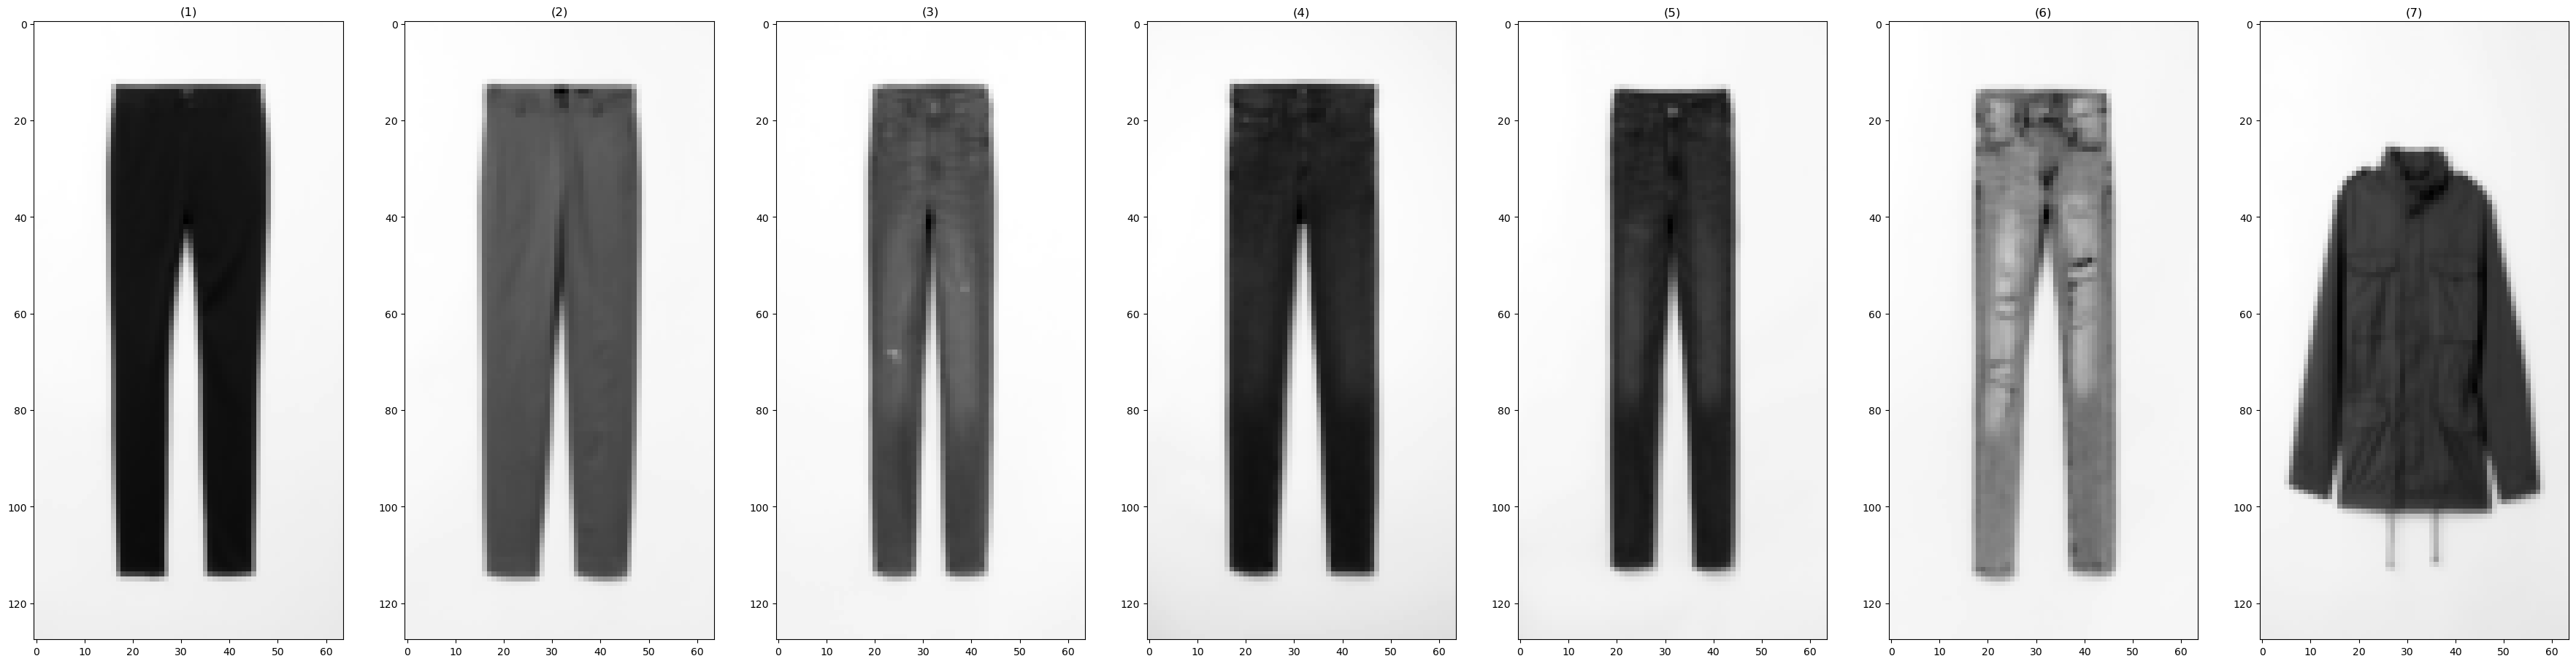

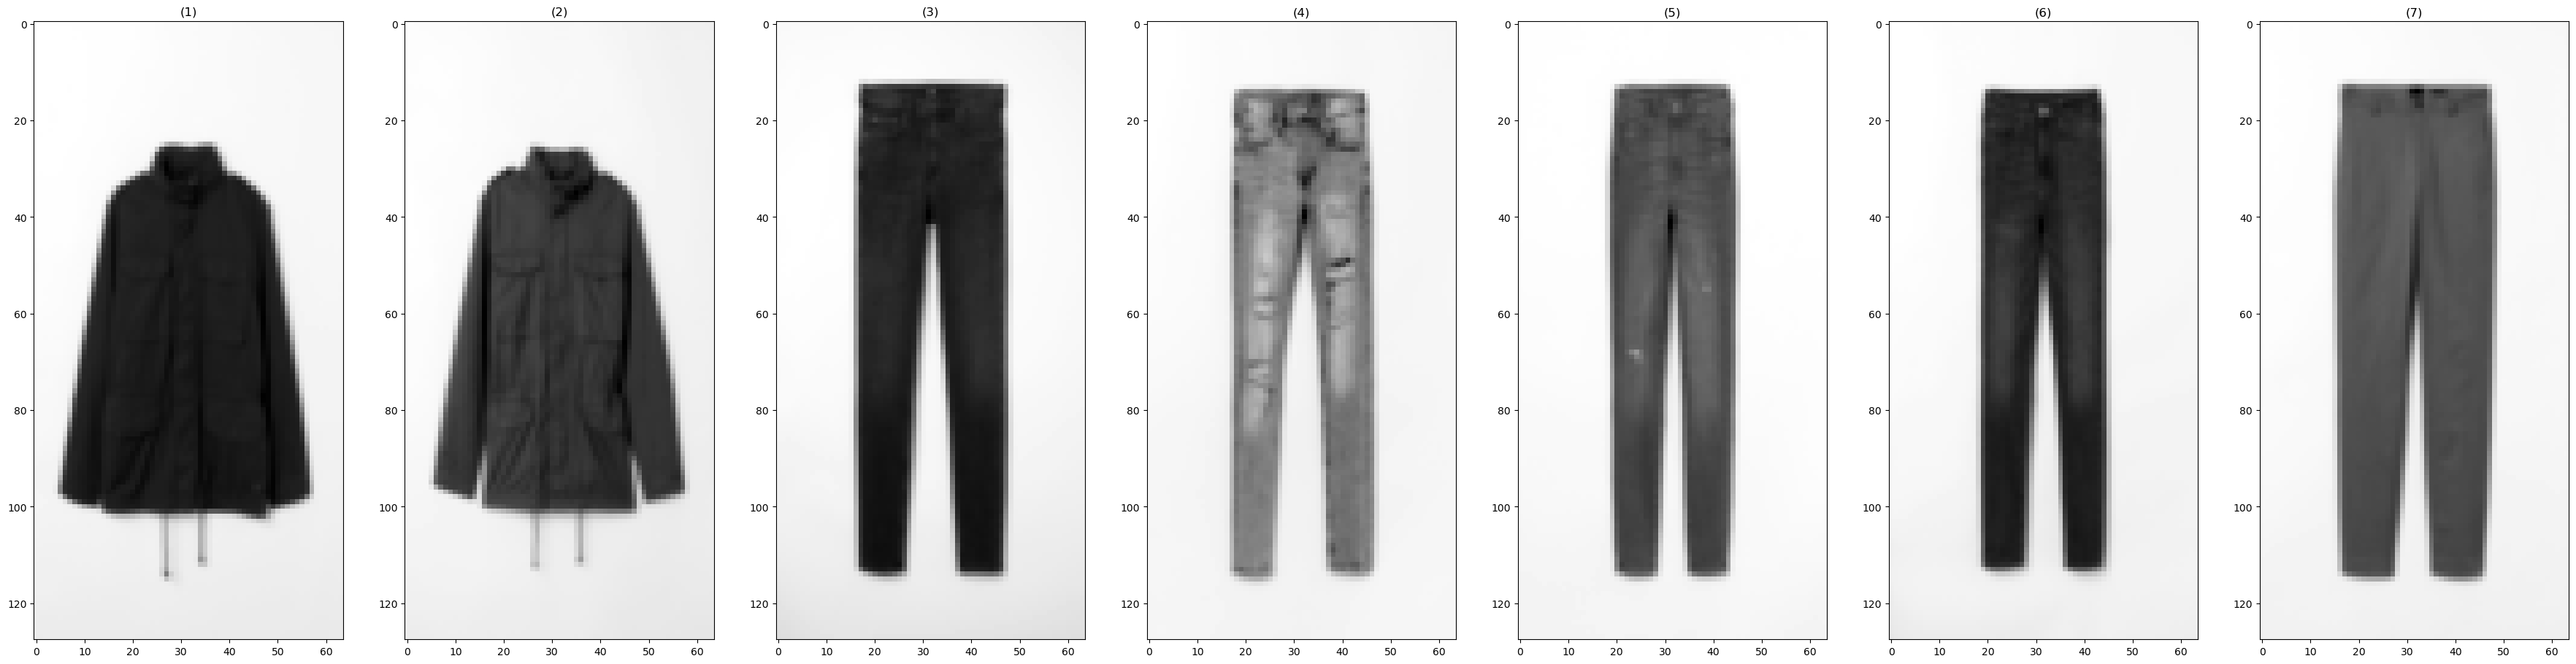

In [33]:
def calculate_distance(feat1: np.ndarray, feat2: np.ndarray) -> float:
    """Calculates the mean squared distance between two feature vectors.

    This function computes the mean squared difference between each corresponding element
    of the two input feature vectors. This distance measure is useful for comparing the 
    similarity between two sets of features in many applications, such as machine learning.

    Parameters:
        - feat1 (np.ndarray): The first feature vector as a NumPy array.
        - feat2 (np.ndarray): The second feature vector as a NumPy array.

    Returns:c
        - float: The mean squared distance between the two feature vectors.
    """
    return np.mean((feat1 - feat2) ** 2)

for r_idx, ref_feat in enumerate(reference_features):
    distances: float = [
        calculate_distance(ref_feat, src_feat) 
        for src_feat in source_features
    ]
    distances_sorted = np.argsort(distances)
    commonfunctions.show_images([read_image(reference_fns[r_idx])] + [read_image(source_fns[idx]) for idx in distances_sorted])